In [1]:
# CELL 1: SETUP AND DATA DOWNLOAD
import os

# 1. Define Paths
# Ensure the data goes into the correct directory structure
project_root = '/content'
data_dir = os.path.join(project_root, 'data')
os.makedirs(data_dir, exist_ok=True)

# 2. Move to data directory
%cd {data_dir}

# 3. Download the dataset folder from Google Drive
!pip install gdown -q
print("Downloading folder from Drive...")
# Downloads the folder structure containing the Linemod dataset
!gdown --folder "https://drive.google.com/drive/folders/19ivHpaKm9dOrr12fzC8IDFczWRPFxho7" --remaining-ok

# 4. Find and Unzip the Linemod dataset
# The download creates a folder (usually named 'DenseFusion')
# Search for 'Linemod_preprocessed.zip' recursively and extract it
import glob
zip_files = glob.glob("**/Linemod_preprocessed.zip", recursive=True)

if zip_files:
    zip_path = zip_files[0]
    print(f"Unzipping {zip_path}...")
    !unzip -q -o "{zip_path}"
    print("Extraction complete!")
else:
    print("Error: Linemod_preprocessed.zip not found. Check the download.")

# 5. Return to Project Root
%cd {project_root}

/content/data
Retrieving folder contents
Processing file 1YFUra533pxS_IHsb9tB87lLoxbcHYXt8 Linemod_preprocessed.zip
Processing file 1gfOnOojzVdEwPzSaPmS3t3aJaQptbys6 trained_checkpoints.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1YFUra533pxS_IHsb9tB87lLoxbcHYXt8
From (redirected): https://drive.google.com/uc?id=1YFUra533pxS_IHsb9tB87lLoxbcHYXt8&confirm=t&uuid=bed2b9ef-9e8c-4fa9-b0cb-a7919af9feed
To: /content/data/DenseFusion/Linemod_preprocessed.zip
100% 8.97G/8.97G [02:03<00:00, 72.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1gfOnOojzVdEwPzSaPmS3t3aJaQptbys6
From (redirected): https://drive.google.com/uc?id=1gfOnOojzVdEwPzSaPmS3t3aJaQptbys6&confirm=t&uuid=6779e349-d5ac-44fd-8f0a-5a218f6b4dea
To: /content/data/DenseFusion/trained_checkpoints.zip
100% 253M/253M [00:04<00:00, 61.3MB/s]
Download completed
Unzipping DenseFusion/Linemod_p

In [5]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/content/6D_pose"   #Modify here for kaggle
branch = "main"

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)

/content/6D_pose
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 10 (delta 5), reused 5 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (10/10), 693.07 KiB | 6.19 MiB/s, done.
From https://github.com/fraco03/6D_pose
   3f10cfc..11dd9ed  pose_rgb   -> origin/pose_rgb
Already on 'main'
Your branch is up to date with 'origin/main'.
HEAD is now at 4135456 Refactor drive mounting function to accept a customizable path
/content
Updated https://github.com/fraco03/6D_pose.git to /content/6D_pose


In [3]:
from google.colab import drive
from utils.load_data import mount_drive

# Mounting part
mount_drive()

dataset_root = "/content/drive/MyDrive/Linemod_preprocessed" #Modify here for kaggle

print("\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")

Mounted at /content/drive
✅ Drive mounted at /content/drive

✅ Setup complete!
📁 Dataset path: /content/drive/MyDrive/Linemod_preprocessed


In [6]:
%pip install ultralytics
from ultralytics import YOLO
from src.detection.yolo_utils import calculate_adapted_map50, visualize_bbox, generate_synthetic_dataset, auto_labeled_dataset

In [5]:
# CELL 3: GENERATE SYNTHETIC TRAINING DATASET WITH COLLAGES
import os
import cv2
import numpy as np
import random
import yaml
import shutil
import requests
from tqdm import tqdm

# --- CONFIGURATION ---
SOURCE_ROOT = '/content/data/Linemod_preprocessed/data'
DEST_ROOT = '/content/datasets'
BG_CACHE_DIR = '/content/backgrounds_cache'

NUM_COLLAGES = 2000      # Number of synthetic collage images to generate
MAX_OBJECTS_PER_IMG = 4  # Maximum objects per collage image

generate_synthetic_dataset(SOURCE_ROOT,DEST_ROOT,BG_CACHE_DIR,NUM_COLLAGES,MAX_OBJECTS_PER_IMG)

🛠️  Setting up directories...
🌍 Downloading background images...
♻️  Loading objects for collages (excluding class 02)...


100%|██████████| 13/13 [00:13<00:00,  1.02s/it]


🚀 Generating 2000 synthetic collages...


100%|██████████| 2000/2000 [00:20<00:00, 98.33it/s] 


📸 Processing real images...


100%|██████████| 13/13 [01:53<00:00,  8.76s/it]


✅ Dataset generated successfully!
   [TRAINING]  Synthetic collages (no class 2):  2000
   [TRAINING]  Real images (class 2 only):       30
   [SKIPPED]   Real training images (others):    374
   [VALIDATION] Real images (all classes):       15396


In [6]:
import os
import random
import shutil
from tqdm import tqdm

# --- CONFIGURATION ---
VAL_IMG_DIR = '/content/datasets/images/val'
VAL_LBL_DIR = '/content/datasets/labels/val'
BACKUP_DIR = '/content/datasets/val_removed_backup' # Folder where excess images will be moved

KEEP_RATIO = 0.20  # Keep only 20% of images (e.g., 10,000 -> 2,000)
                   # Increase this if you want more validation data

# --- SCRIPT START ---
print(f"🧹 Starting Validation dataset cleanup...")

if not os.path.exists(VAL_IMG_DIR):
    raise FileNotFoundError(f"❌ Error: Directory {VAL_IMG_DIR} does not exist!")

# 1. List all valid image files
all_images = [f for f in os.listdir(VAL_IMG_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
total_count = len(all_images)

# 2. Calculate how many to keep and how many to move
keep_count = int(total_count * KEEP_RATIO)
remove_count = total_count - keep_count

print(f"📊 Total images found: {total_count}")
print(f"✅ To keep (Active):    {keep_count}")
print(f"📦 To move (Backup):    {remove_count}")

if remove_count <= 0:
    print("⚠️ No images to remove (Ratio is too high or dataset is too small). Exiting.")
    exit()

# 3. Shuffle the list to ensure random selection
random.shuffle(all_images)
images_to_remove = all_images[:remove_count]

# 4. Create backup directories if they don't exist
os.makedirs(os.path.join(BACKUP_DIR, 'images'), exist_ok=True)
os.makedirs(os.path.join(BACKUP_DIR, 'labels'), exist_ok=True)

# 5. Move files loop
print("🚀 Moving files to backup folder...")
moved_count = 0

for img_name in tqdm(images_to_remove, desc="Processing"):
    # Define Image Paths
    src_img = os.path.join(VAL_IMG_DIR, img_name)
    dst_img = os.path.join(BACKUP_DIR, 'images', img_name)

    # Define Label Paths (corresponding .txt file)
    lbl_name = os.path.splitext(img_name)[0] + '.txt'
    src_lbl = os.path.join(VAL_LBL_DIR, lbl_name)
    dst_lbl = os.path.join(BACKUP_DIR, 'labels', lbl_name)

    try:
        # Move Image
        shutil.move(src_img, dst_img)

        # Move Label (only if it exists)
        if os.path.exists(src_lbl):
            shutil.move(src_lbl, dst_lbl)

        moved_count += 1
    except Exception as e:
        print(f"❌ Error moving {img_name}: {e}")

print(f"\n✅ OPERATION COMPLETED!")
print(f"   The folder {VAL_IMG_DIR} now contains approximately {len(os.listdir(VAL_IMG_DIR))} images.")
print(f"   Excess files have been safely moved to: {BACKUP_DIR}")

🧹 Starting Validation dataset cleanup...
📊 Total images found: 15396
✅ To keep (Active):    3079
📦 To move (Backup):    12317
🚀 Moving files to backup folder...


Processing: 100%|██████████| 12317/12317 [00:01<00:00, 11682.09it/s]


✅ OPERATION COMPLETED!
   The folder /content/datasets/images/val now contains approximately 3079 images.
   Excess files have been safely moved to: /content/datasets/val_removed_backup


In [7]:
# CELL 4: TRAIN YOLO MODEL ON SYNTHETIC DATA
import torch

# --- 1. HARDWARE CHECK ---
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ WARNING: Using CPU! Go to Runtime > Change runtime type > T4 GPU")

# --- 2. MODEL SELECTION ---
# YOLO11 Small is perfect for T4 GPU
model = YOLO('yolo11s.pt')

print("🚀 Starting Training on Colab T4...")

# --- 3. TRAINING LOOP ---
results = model.train(
    data='/content/linemod.yaml',

    # --- DURATION ---
    epochs=50,           # Increased to 50. Synthetic data requires more time to converge
    patience=15,         # Early stopping if no improvement for 15 epochs

    # --- HARDWARE ---
    imgsz=640,
    batch=32,            # Batch size 16 is safer and more stable for generalization on difficult datasets
    device=0,
    workers=2,
    amp=True,            # Mixed Precision ON (Essential for T4)
    cache=True,         # Save RAM

    # --- AUGMENTATION (Tuned for "Black-on-Black" scenarios) ---
    mosaic=0.5,          # REDUCED. Data is already collaged, don't overdo it
    mixup=0.0,           # DISABLED. Critical! We want solid objects, not transparent ghosts

    degrees=10.0,        # Light rotation (already done in generator script)
    scale=0.5,           # Zoom in/out
    translate=0.1,       # Light translation
    fliplr=0.5,          # Horizontal flip OK

    # --- LIGHTING (YOLO applies these instead of our script) ---
    hsv_h=0.015,         # Light color shift
    hsv_s=0.7,           # Saturation
    hsv_v=0.4,           # BRIGHTNESS (Value): 0.4 is perfect
                         # Teaches the model: "The phone is the same whether dark (black) or illuminated (gray)"

    close_mosaic=10,     # Last 10 epochs turn off mosaic to refine edges

    # --- SAVE RESULTS ---
    # WARNING: This saves directly to Google Drive
    project='/content/drive/MyDrive/YOLO_Runs',
    name='yolo11_collage_run',
    verbose=True,
    exist_ok=True,
    save=True
)

✅ GPU: Tesla T4
🚀 Starting Training on Colab T4...
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/linemod.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=0.5, multi_scale=False, name=yolo11_collage_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tr


image 1/1 /content/dataset_AUTOLABELED/images/train/01_1019.png: 480x640 1 ape, 1 can, 1 cat, 1 duck, 1 eggbox, 2 holepunchers, 103.7ms
Speed: 4.0ms preprocess, 103.7ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


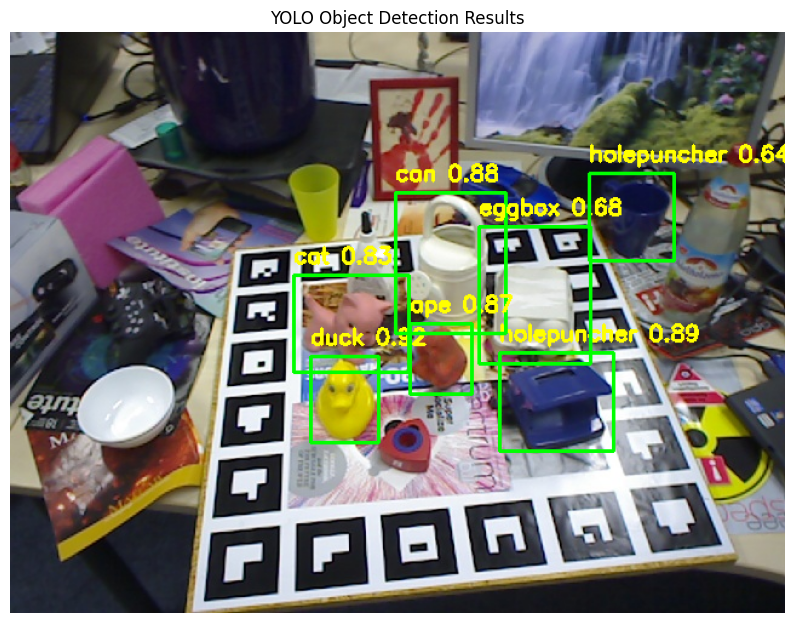

In [17]:
# YOLO INFERENCE - OBJECT DETECTION ON TEST IMAGES
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 1. Load Trained Model
model = YOLO('/content/drive/MyDrive/YOLO_Runs/yolo11_collage_run/weights/best.pt')  # Path to your trained model weights
CONF = 0.5  # Confidence threshold for detections

# 2. Define Class Names (Override)
# Tell the model: "Use these class names instead of the default ones"
new_names = {
    0: 'ape', 1: 'benchvise', 2: 'camera', 3: 'can', 4: 'cat',
    5: 'driller', 6: 'duck', 7: 'eggbox', 8: 'glue', 9: 'holepuncher',
    10: 'iron', 11: 'lamp', 12: 'phone'
}

# 3. Run Inference
img_path = '/content/dataset_AUTOLABELED/images/train/01_1019.png'  # Path to the test image
results = model.predict(img_path, conf=CONF)

# 4. Visualize Results with Corrected Names
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Iterate through detected objects
for box in results[0].boxes:
    cls_id = int(box.cls[0])  # Class ID
    conf = float(box.conf[0])  # Confidence score

    # Use the corrected class names
    name = new_names[cls_id]

    # Get bounding box coordinates
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)

    # Draw bounding box and label on image
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, f"{name} {conf:.2f}", (x1, y1-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.title('YOLO Object Detection Results')
plt.show()

In [10]:
# CELL 6: AUTO-LABELING - USE TRAINED MODEL TO ADD MISSING LABELS
import os
import cv2
import numpy as np
import yaml
import shutil
from ultralytics import YOLO
from tqdm import tqdm

# --- CONFIGURATION ---
SOURCE_ROOT = '/content/data/Linemod_preprocessed/data'
DEST_ROOT = '/content/dataset_AUTOLABELED'
MODEL_PATH = '/content/drive/MyDrive/YOLO_Runs/yolo11_collage_run/weights/best.pt'

# Auto-labeling thresholds
CONF_THRESHOLD = 0.70   # Minimum confidence to add predicted label
IOU_THRESHOLD = 0.45    # IoU threshold to detect duplicates with ground truth

auto_labeled_dataset(DEST_ROOT, MODEL_PATH, SOURCE_ROOT, CONF_THRESHOLD, IOU_THRESHOLD )

🧠 Loading model: /content/drive/MyDrive/YOLO_Runs/yolo11_collage_run/weights/best.pt
🚀 Starting auto-labeling process...


Folder 01: 100%|██████████| 1236/1236 [00:55<00:00, 22.31it/s]


KeyboardInterrupt: 

In [ ]:
import os
import random
import shutil
from tqdm import tqdm

# --- CONFIGURATION ---
VAL_IMG_DIR = '/content/dataset_AUTOLABELED/images/val'
VAL_LBL_DIR = '/content/dataset_AUTOLABELED/labels/val'
BACKUP_DIR = '/content/dataset_AUTOLABELED/val_removed_backup' # Folder where excess images will be moved

KEEP_RATIO = 0.20  # Keep only 20% of images (e.g., 10,000 -> 2,000)
                   # Increase this if you want more validation data

# --- SCRIPT START ---
print(f"🧹 Starting Validation dataset cleanup...")

if not os.path.exists(VAL_IMG_DIR):
    raise FileNotFoundError(f"❌ Error: Directory {VAL_IMG_DIR} does not exist!")

# 1. List all valid image files
all_images = [f for f in os.listdir(VAL_IMG_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]
total_count = len(all_images)

# 2. Calculate how many to keep and how many to move
keep_count = int(total_count * KEEP_RATIO)
remove_count = total_count - keep_count

print(f"📊 Total images found: {total_count}")
print(f"✅ To keep (Active):    {keep_count}")
print(f"📦 To move (Backup):    {remove_count}")

if remove_count <= 0:
    print("⚠️ No images to remove (Ratio is too high or dataset is too small). Exiting.")
    exit()

# 3. Shuffle the list to ensure random selection
random.shuffle(all_images)
images_to_remove = all_images[:remove_count]

# 4. Create backup directories if they don't exist
os.makedirs(os.path.join(BACKUP_DIR, 'images'), exist_ok=True)
os.makedirs(os.path.join(BACKUP_DIR, 'labels'), exist_ok=True)

# 5. Move files loop
print("🚀 Moving files to backup folder...")
moved_count = 0

for img_name in tqdm(images_to_remove, desc="Processing"):
    # Define Image Paths
    src_img = os.path.join(VAL_IMG_DIR, img_name)
    dst_img = os.path.join(BACKUP_DIR, 'images', img_name)

    # Define Label Paths (corresponding .txt file)
    lbl_name = os.path.splitext(img_name)[0] + '.txt'
    src_lbl = os.path.join(VAL_LBL_DIR, lbl_name)
    dst_lbl = os.path.join(BACKUP_DIR, 'labels', lbl_name)

    try:
        # Move Image
        shutil.move(src_img, dst_img)

        # Move Label (only if it exists)
        if os.path.exists(src_lbl):
            shutil.move(src_lbl, dst_lbl)

        moved_count += 1
    except Exception as e:
        print(f"❌ Error moving {img_name}: {e}")

print(f"\n✅ OPERATION COMPLETED!")
print(f"   The folder {VAL_IMG_DIR} now contains approximately {len(os.listdir(VAL_IMG_DIR))} images.")
print(f"   Excess files have been safely moved to: {BACKUP_DIR}")

In [ ]:
# CELL 8: TEST VISUALIZATION FUNCTION
visualize_bbox('/content/dataset_AUTOLABELED/images/train/01_1002.png')

In [ ]:
# CELL 9: FINAL TRAINING ON AUTO-LABELED DATASET
from ultralytics import YOLO

# Use the 's' (Small) clean version
# Will automatically download standard weights if not found
model = YOLO('yolo11s.pt')

results = model.train(
    # The clean dataset with automatic labels
    data='/content/dataset_AUTOLABELED/data.yaml',

    # --- DURATION ---
    epochs=50,
    patience=15,

    # --- HARDWARE ---
    imgsz=640,
    batch=32,            # With the 's' model, use 16 to avoid running out of video memory (OOM)
    device=0,
    workers=4,
    cache=True,
    # --- AUGMENTATION ---
    mosaic=1.0,          # Now that labels are good, mosaic is useful
    mixup=0.1,           # Light mixup

    degrees=10.0,
    fliplr=0.5,
    scale=0.5,

    # --- OUTPUT ---
    project='/content/drive/MyDrive/YOLO_Runs',
    name='yolo11s_autolabel_final_with_70_th', # Changed name to remind it's the S model
    save=True,
    exist_ok=True
)

In [ ]:
calculate_adapted_map50('/content/drive/MyDrive/YOLO_Runs/yolo11s_autolabel_final/weights/best.pt',
                        '/content/data/Linemod_preprocessed/data')